In [1]:
import datetime
from statistics import mean
from pprint import pprint

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from data import tfrecord_dataset, classification_dataset, train_test_split
from train import train_model, get_best_num_epochs
from layers import SeluConv3D, SeluDense
from plot import plot_slice, plot_volume_animation
from config import (
    LIDC_SMALL_NEG_TFRECORD,
    LIDC_BIG_NEG_TFRECORD,
    LIDC_SMALL_POS_TFRECORD,
    LIDC_BIG_POS_TFRECORD,
    LIDC_SMALL_UNLABELED_TFRECORD,
    SPIE_SMALL_NEG_TFRECORD,
    SPIE_BIG_NEG_TFRECORD,
    SPIE_SMALL_POS_TFRECORD,
    SPIE_BIG_POS_TFRECORD,
    SMALL_PATCH_SHAPE,
    BIG_PATCH_SHAPE,
    SEED,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

In [2]:
unlabeled_dataset = tfrecord_dataset(
    [LIDC_SMALL_NEG_TFRECORD, LIDC_SMALL_POS_TFRECORD, LIDC_SMALL_UNLABELED_TFRECORD]
)
unlabeled_dataset = tf.data.Dataset.zip((unlabeled_dataset, unlabeled_dataset))
unlabeled_samples = sum(1 for _ in unlabeled_dataset)
unlabeled_samples

1139

In [3]:
# Hyperparameters
val_perc = 0.1
batch_size = 16

In [4]:
train_dataset, val_dataset = train_test_split(
    unlabeled_dataset,
    test_perc=val_perc,
    cardinality=unlabeled_samples,
)
val_dataset = (
    val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset

<PrefetchDataset shapes: ((None, None, None, None, None), (None, None, None, None, None)), types: (tf.float32, tf.float32)>

In [5]:
def build_autoencoder():
    encoder = keras.Sequential(
        [
            keras.layers.InputLayer(SMALL_PATCH_SHAPE, name="encoder_input"),
            SeluConv3D(filters=32, kernel_size=3, name="encoder_selu_conv3d_1"),
            keras.layers.MaxPooling3D((1, 2, 2), name="maxpool_1"),
            SeluConv3D(filters=64, kernel_size=3, name="encoder_selu_conv3d_2"),
            keras.layers.MaxPooling3D((1, 2, 2), name="maxpool_2"),
            SeluConv3D(filters=128, kernel_size=3, name="encoder_selu_conv3d_3"),
            keras.layers.MaxPooling3D((1, 2, 2), name="maxpool_3"),
            SeluConv3D(filters=256, kernel_size=3, name="encoder_selu_conv3d_4"),
        ],
        name="encoder",
    )
    decoder = keras.Sequential(
        [
            keras.layers.InputLayer(encoder.output_shape[1:], name="decoder_input"),
            SeluConv3D(filters=256, kernel_size=3, name="decoder_selu_conv3d_1"),
            keras.layers.UpSampling3D((1, 2, 2), name="upsampling_2"),
            SeluConv3D(filters=128, kernel_size=3, name="decoder_selu_conv3d_2"),
            keras.layers.UpSampling3D((1, 2, 2), name="upsampling_3"),
            SeluConv3D(filters=64, kernel_size=3, name="decoder_selu_conv3d_3"),
            keras.layers.UpSampling3D((1, 2, 2), name="upsampling_4"),
            SeluConv3D(filters=32, kernel_size=3, name="decoder_selu_conv3d_4"),
            keras.layers.Dense(1, activation="sigmoid", name="decoder_final_dense"),
        ],
        name="decoder",
    )

    autoencoder = keras.Sequential(
        [
            keras.layers.InputLayer(SMALL_PATCH_SHAPE, name="autoencoder_input"),
            encoder,
            decoder,
        ],
        name="autoencoder",
    )
    return autoencoder

In [6]:
patience = 30
learning_rate = 1e-5

In [7]:
autoencoder = build_autoencoder()
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
)
num_epochs = get_best_num_epochs(
    autoencoder,
    train_dataset,
    val_dataset,
    patience,
    "val_loss",
    verbose_training=1,
    verbose_early_stopping=1,
)
num_epochs

Epoch 1/1000
65/65 [==============================] - 2s 36ms/step - loss: 0.0805 - val_loss: 0.0375
Epoch 2/1000
65/65 [==============================] - 2s 28ms/step - loss: 0.0503 - val_loss: 0.0328
Epoch 3/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0468 - val_loss: 0.0300
Epoch 4/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0447 - val_loss: 0.0287
Epoch 5/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0435 - val_loss: 0.0278
Epoch 6/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0427 - val_loss: 0.0272
Epoch 7/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0421 - val_loss: 0.0269
Epoch 8/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0417 - val_loss: 0.0262
Epoch 9/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0413 - val_loss: 0.0259
Epoch 10/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0410 - val_lo

Epoch 161/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0360 - val_loss: 0.0212
Epoch 162/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0359 - val_loss: 0.0212
Epoch 163/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0359 - val_loss: 0.0212
Epoch 164/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0359 - val_loss: 0.0212
Epoch 165/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0360 - val_loss: 0.0212
Epoch 166/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0359 - val_loss: 0.0212
Epoch 167/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0359 - val_loss: 0.0212
Epoch 168/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0359 - val_loss: 0.0211
Epoch 169/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0360 - val_loss: 0.0211
Epoch 170/1000
65/65 [==============================] - 2s 29ms/step - lo

65/65 [==============================] - 2s 29ms/step - loss: 0.0352 - val_loss: 0.0206
Epoch 320/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0352 - val_loss: 0.0206
Epoch 321/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0352 - val_loss: 0.0206
Epoch 322/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0352 - val_loss: 0.0207
Epoch 323/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0353 - val_loss: 0.0207
Epoch 324/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0352 - val_loss: 0.0206
Epoch 325/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0352 - val_loss: 0.0207
Epoch 326/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0352 - val_loss: 0.0206
Epoch 327/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0352 - val_loss: 0.0206
Epoch 328/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0352 - va

65/65 [==============================] - 2s 29ms/step - loss: 0.0349 - val_loss: 0.0205
Epoch 478/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0349 - val_loss: 0.0204
Epoch 479/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0349 - val_loss: 0.0205
Epoch 480/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0349 - val_loss: 0.0204
Epoch 481/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0349 - val_loss: 0.0205
Epoch 482/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0349 - val_loss: 0.0205
Epoch 483/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0349 - val_loss: 0.0204
Epoch 484/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0349 - val_loss: 0.0205
Epoch 485/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0349 - val_loss: 0.0204
Epoch 486/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0349 - va

65/65 [==============================] - 2s 29ms/step - loss: 0.0347 - val_loss: 0.0204
Epoch 636/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0347 - val_loss: 0.0204
Epoch 637/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0347 - val_loss: 0.0204
Epoch 638/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0347 - val_loss: 0.0204
Epoch 639/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0347 - val_loss: 0.0204
Epoch 640/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0347 - val_loss: 0.0204
Epoch 641/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0347 - val_loss: 0.0204
Epoch 642/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.0347 - val_loss: 0.0204
Epoch 00642: early stopping


611

In [12]:
train_dataset = (
    unlabeled_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset

<PrefetchDataset shapes: ((None, None, None, None, None), (None, None, None, None, None)), types: (tf.float32, tf.float32)>

In [13]:
# train for more epochs because the training set will be bigger
extra_epochs = 10

In [14]:
autoencoder = build_autoencoder()
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
)

model_fname = f"models/autoencoder-lidc.h5"
log_dir = f"logs/autoencoder-lidc"
autoencoder = train_model(
    autoencoder,
    train_dataset,
    num_epochs + extra_epochs,
    model_fname,
    log_dir,
)

In [17]:
original, _ = next(iter(val_dataset.skip(2)))
encoder_out = autoencoder.get_layer("encoder")(original, training=False)
decoder_out = autoencoder.get_layer("decoder")(encoder_out, training=False)
plot_volume_animation(original[0, :])

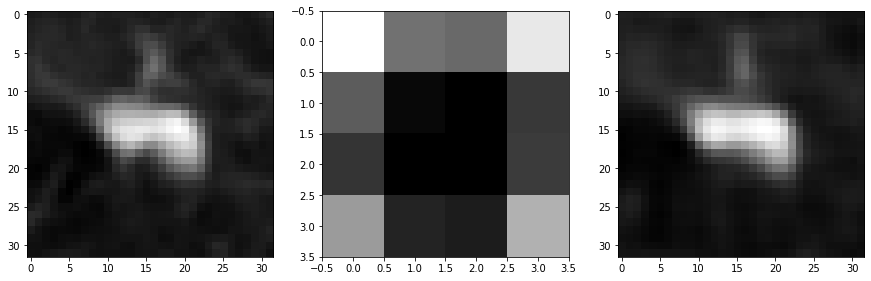

In [18]:
batch_index = 0
z_index = 3
fig, ax = plt.subplots(ncols=3)
plot_slice(original[batch_index, :], index=z_index, ax=ax[0])
plot_slice(encoder_out[batch_index, :], index=z_index, ax=ax[1])
plot_slice(decoder_out[batch_index, :], index=z_index, ax=ax[2])

In [2]:
labeled_dataset, labeled_samples = classification_dataset(
    LIDC_SMALL_NEG_TFRECORD,
    LIDC_BIG_NEG_TFRECORD,
    LIDC_SMALL_POS_TFRECORD,
    LIDC_BIG_POS_TFRECORD,
    return_size=True,
)
labeled_samples

754

In [3]:
val_perc = 0.1
batch_size = 16

In [4]:
train_dataset, val_dataset = train_test_split(
    labeled_dataset,
    test_perc=val_perc,
    cardinality=labeled_samples,
)
val_dataset = (
    val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset

<PrefetchDataset shapes: (((None, None, None, None, None), (None, None, None, None, None)), (None, 1)), types: ((tf.float32, tf.float32), tf.int8)>

In [5]:
dropout_rate = 0.6

In [6]:
def build_3d_cnn():
    input_small = keras.Input(SMALL_PATCH_SHAPE, name="input_small")
    x_small = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="small_selu_conv3d_1",
    )(input_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_1")(x_small)
    x_small = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="small_selu_conv3d_2",
    )(x_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_2")(x_small)
    x_small = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="small_selu_conv3d_3",
    )(x_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_3")(x_small)
    x_small = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="small_selu_conv3d_4",
    )(x_small)
    x_small = keras.layers.Flatten(name="flatten_small")(x_small)

    input_big = keras.Input(BIG_PATCH_SHAPE, name="input_big")
    x_big = keras.layers.MaxPooling3D((2, 2, 2), name="big_maxpool_0")(input_big)
    x_big = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="big_selu_conv3d_1",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_1")(x_big)
    x_big = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="big_selu_conv3d_2",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_2")(x_big)
    x_big = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="big_selu_conv3d_3",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_3")(x_big)
    x_big = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="big_selu_conv3d_4",
    )(x_big)
    x_big = keras.layers.Flatten(name="flatten_big")(x_big)

    x = keras.layers.concatenate([x_small, x_big], name="concatenate")
    x = SeluDense(128, name="selu_dense")(x)
    x = keras.layers.AlphaDropout(dropout_rate, name="alpha_dropout")(x)
    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(x)

    cnn_3d = keras.Model(inputs=[input_small, input_big], outputs=x, name="3dcnn")

    return cnn_3d

In [7]:
metrics = [
    keras.metrics.AUC(name="auc"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]

In [8]:
learning_rate = 1e-5
patience = 15

In [9]:
cnn = build_3d_cnn()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
    metrics=metrics,
)
num_epochs = get_best_num_epochs(
    cnn,
    train_dataset,
    val_dataset,
    patience,
    "val_loss",
    verbose_training=1,
    verbose_early_stopping=1,
)
num_epochs

Epoch 1/1000
43/43 [==============================] - 1s 34ms/step - loss: 0.2719 - auc: 0.5891 - accuracy: 0.5641 - val_loss: 0.1946 - val_auc: 0.8571 - val_accuracy: 0.7333
Epoch 2/1000
43/43 [==============================] - 1s 18ms/step - loss: 0.2048 - auc: 0.7511 - accuracy: 0.6981 - val_loss: 0.1616 - val_auc: 0.8829 - val_accuracy: 0.7867
Epoch 3/1000
43/43 [==============================] - 1s 18ms/step - loss: 0.2036 - auc: 0.7542 - accuracy: 0.6996 - val_loss: 0.1392 - val_auc: 0.8932 - val_accuracy: 0.7867
Epoch 4/1000
43/43 [==============================] - 1s 18ms/step - loss: 0.1878 - auc: 0.7916 - accuracy: 0.7231 - val_loss: 0.1314 - val_auc: 0.8996 - val_accuracy: 0.8133
Epoch 5/1000
43/43 [==============================] - 1s 17ms/step - loss: 0.1858 - auc: 0.7938 - accuracy: 0.7187 - val_loss: 0.1396 - val_auc: 0.8964 - val_accuracy: 0.8000
Epoch 6/1000
43/43 [==============================] - 1s 18ms/step - loss: 0.1794 - auc: 0.8072 - accuracy: 0.7364 - val_loss

43/43 [==============================] - 1s 17ms/step - loss: 0.0529 - auc: 0.9846 - accuracy: 0.9426 - val_loss: 0.1399 - val_auc: 0.9236 - val_accuracy: 0.8267
Epoch 48/1000
43/43 [==============================] - 1s 18ms/step - loss: 0.0571 - auc: 0.9813 - accuracy: 0.9264 - val_loss: 0.1345 - val_auc: 0.9211 - val_accuracy: 0.8267
Epoch 49/1000
43/43 [==============================] - 1s 18ms/step - loss: 0.0544 - auc: 0.9853 - accuracy: 0.9278 - val_loss: 0.1348 - val_auc: 0.9225 - val_accuracy: 0.8267
Epoch 50/1000
43/43 [==============================] - 1s 17ms/step - loss: 0.0538 - auc: 0.9847 - accuracy: 0.9278 - val_loss: 0.1404 - val_auc: 0.9100 - val_accuracy: 0.8133
Epoch 00050: early stopping


34

In [10]:
train_dataset = (
    labeled_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset

<PrefetchDataset shapes: (((None, None, None, None, None), (None, None, None, None, None)), (None, 1)), types: ((tf.float32, tf.float32), tf.int8)>

In [11]:
# train for more epochs because the training set will be bigger
extra_epochs = 5

In [12]:
cnn = build_3d_cnn()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
    metrics=metrics,
)

model_fname = f"models/3dcnn-lidc.h5"
log_dir = f"logs/3dcnn-lidc"
cnn = train_model(
    cnn,
    train_dataset,
    num_epochs + extra_epochs,
    model_fname,
    log_dir,
)

In [22]:
def build_pretrained_3d_cnn():
    small_encoder = keras.models.load_model("models/autoencoder-lidc.h5").get_layer(
        "encoder"
    )
    small_encoder._name = "small_encoder"
    for layer in small_encoder.layers:
        layer._name = "small_" + layer._name
    small_encoder.trainable = False

    input_small = keras.Input(SMALL_PATCH_SHAPE, name="input_small")
    x_small = small_encoder(input_small)
    x_small = keras.layers.Flatten(name="flatten_small")(x_small)

    big_encoder = keras.models.load_model("models/autoencoder-lidc.h5").get_layer(
        "encoder"
    )
    big_encoder._name = "big_encoder"
    for layer in big_encoder.layers:
        layer._name = "big_" + layer._name
    big_encoder.trainable = False

    input_big = keras.Input(BIG_PATCH_SHAPE, name="input_big")
    x_big = keras.layers.MaxPooling3D((2, 2, 2), name="big_maxpool_0")(input_big)
    x_big = big_encoder(x_big)
    x_big = keras.layers.Flatten(name="flatten_big")(x_big)

    x = keras.layers.concatenate([x_small, x_big], name="concatenate")

    x = SeluDense(128, name="selu_dense")(x)
    x = keras.layers.AlphaDropout(dropout_rate, name="alpha_dropout")(x)
    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(x)

    cnn_3d = keras.Model(inputs=[input_small, input_big], outputs=x, name="3dcnn")

    return cnn_3d

In [24]:
train_dataset, val_dataset = train_test_split(
    labeled_dataset,
    test_perc=val_perc,
    cardinality=labeled_samples,
)
val_dataset = (
    val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset

<PrefetchDataset shapes: (((None, None, None, None, None), (None, None, None, None, None)), (None, 1)), types: ((tf.float32, tf.float32), tf.int8)>

In [23]:
cnn = build_pretrained_3d_cnn()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
    metrics=metrics,
)
num_epochs = get_best_num_epochs(
    cnn,
    train_dataset,
    val_dataset,
    patience,
    "val_loss",
    verbose_training=1,
    verbose_early_stopping=1,
)
num_epochs

Epoch 1/1000
48/48 [==============================] - 1s 15ms/step - loss: 0.2415 - auc: 0.8556 - accuracy: 0.7699 - val_loss: 0.1146 - val_auc: 0.9171 - val_accuracy: 0.8400
Epoch 2/1000
48/48 [==============================] - 0s 9ms/step - loss: 0.1982 - auc: 0.7654 - accuracy: 0.6830 - val_loss: 0.1072 - val_auc: 0.9482 - val_accuracy: 0.8400
Epoch 3/1000
48/48 [==============================] - 0s 9ms/step - loss: 0.1681 - auc: 0.8316 - accuracy: 0.7533 - val_loss: 0.1191 - val_auc: 0.9486 - val_accuracy: 0.8133
Epoch 4/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.1668 - auc: 0.8332 - accuracy: 0.7639 - val_loss: 0.1054 - val_auc: 0.9429 - val_accuracy: 0.8533
Epoch 5/1000
48/48 [==============================] - 0s 9ms/step - loss: 0.1536 - auc: 0.8596 - accuracy: 0.7759 - val_loss: 0.1453 - val_auc: 0.9486 - val_accuracy: 0.8133
Epoch 6/1000
48/48 [==============================] - 0s 9ms/step - loss: 0.1607 - auc: 0.8438 - accuracy: 0.7599 - val_loss: 0.0

Epoch 48/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0645 - auc: 0.9781 - accuracy: 0.9191 - val_loss: 0.0146 - val_auc: 0.9986 - val_accuracy: 0.9733
Epoch 49/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0544 - auc: 0.9858 - accuracy: 0.9403 - val_loss: 0.0216 - val_auc: 0.9986 - val_accuracy: 0.9733
Epoch 50/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0603 - auc: 0.9813 - accuracy: 0.9164 - val_loss: 0.0235 - val_auc: 0.9993 - val_accuracy: 0.9733
Epoch 51/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0572 - auc: 0.9839 - accuracy: 0.9244 - val_loss: 0.0173 - val_auc: 0.9993 - val_accuracy: 0.9733
Epoch 52/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0577 - auc: 0.9827 - accuracy: 0.9284 - val_loss: 0.0119 - val_auc: 0.9993 - val_accuracy: 0.9867
Epoch 53/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0476 - auc: 0.9913 - accuracy: 0.9536 - val_loss

Epoch 95/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0324 - auc: 0.9960 - accuracy: 0.9682 - val_loss: 0.0044 - val_auc: 1.0000 - val_accuracy: 0.9867
Epoch 96/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0307 - auc: 0.9967 - accuracy: 0.9708 - val_loss: 0.0013 - val_auc: 1.0000 - val_accuracy: 1.0000
Epoch 97/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0334 - auc: 0.9952 - accuracy: 0.9695 - val_loss: 0.0012 - val_auc: 1.0000 - val_accuracy: 1.0000
Epoch 98/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0297 - auc: 0.9967 - accuracy: 0.9682 - val_loss: 5.5878e-04 - val_auc: 1.0000 - val_accuracy: 1.0000
Epoch 99/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0362 - auc: 0.9926 - accuracy: 0.9576 - val_loss: 6.0079e-04 - val_auc: 1.0000 - val_accuracy: 1.0000
Epoch 100/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0276 - auc: 0.9969 - accuracy: 0.9735 -

Epoch 141/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0196 - auc: 0.9988 - accuracy: 0.9828 - val_loss: 0.0018 - val_auc: 1.0000 - val_accuracy: 1.0000
Epoch 142/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0201 - auc: 0.9985 - accuracy: 0.9775 - val_loss: 8.2454e-05 - val_auc: 1.0000 - val_accuracy: 1.0000
Epoch 143/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0174 - auc: 0.9993 - accuracy: 0.9841 - val_loss: 1.2253e-04 - val_auc: 1.0000 - val_accuracy: 1.0000
Epoch 144/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0169 - auc: 0.9992 - accuracy: 0.9828 - val_loss: 0.0020 - val_auc: 1.0000 - val_accuracy: 1.0000
Epoch 145/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0171 - auc: 0.9988 - accuracy: 0.9814 - val_loss: 3.9539e-05 - val_auc: 1.0000 - val_accuracy: 1.0000
Epoch 146/1000
48/48 [==============================] - 0s 8ms/step - loss: 0.0182 - auc: 0.9986 - accuracy:

KeyboardInterrupt: 

In [25]:
train_dataset = (
    labeled_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset

<PrefetchDataset shapes: (((None, None, None, None, None), (None, None, None, None, None)), (None, 1)), types: ((tf.float32, tf.float32), tf.int8)>

In [26]:
# train for more epochs because the training set will be bigger
extra_epochs = 10

In [ ]:
cnn = build_pretrained_3d_cnn()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
    metrics=metrics,
)

model_fname = f"models/3dcnn-lidc.h5"
log_dir = f"logs/3dcnn-lidc"
cnn = train_model(
    cnn,
    train_dataset,
    num_epochs + extra_epochs,
    model_fname,
    log_dir,
)

In [19]:
cnn = keras.models.load_model("models/pretrained-3dcnn-lidc.h")
cnn.trainable = True

model_fname = f"models/finetuned-3dcnn-lidc.h5"
log_dir = f"logs/finetuned-3dcnn-lidc"
cnn = train_model(
    cnn,
    train_dataset,
    10,
    model_fname,
    log_dir,
)

In [14]:
spie_dataset, spie_samples = classification_dataset(
    SPIE_SMALL_NEG_TFRECORD,
    SPIE_BIG_NEG_TFRECORD,
    SPIE_SMALL_POS_TFRECORD,
    SPIE_BIG_POS_TFRECORD,
    return_size=True,
)
spie_samples

73

In [15]:
cnn = keras.models.load_model("models/3dcnn-lidc.h5")
cnn.evaluate(spie_dataset.batch(1), return_dict=True)

73/73 [==============================] - 0s 4ms/step - loss: 0.4091 - auc: 0.6239 - accuracy: 0.5616


{'loss': 0.4090675413608551,
 'auc': 0.6238738894462585,
 'accuracy': 0.5616438388824463}

In [16]:
cnn = keras.models.load_model("models/pretrained-3dcnn-lidc.h")
cnn.evaluate(spie_dataset.batch(1), return_dict=True)

73/73 [==============================] - 0s 3ms/step - loss: 0.3896 - auc: 0.6351 - accuracy: 0.5753


{'loss': 0.3895767331123352,
 'auc': 0.6351351737976074,
 'accuracy': 0.5753424763679504}

In [21]:
cnn = keras.models.load_model("models/finetuned-3dcnn-lidc.h5")
cnn.evaluate(spie_dataset.batch(1), return_dict=True)

73/73 [==============================] - 0s 3ms/step - loss: 0.4307 - auc: 0.6400 - accuracy: 0.5479


{'loss': 0.4307129681110382,
 'auc': 0.6400150060653687,
 'accuracy': 0.5479452013969421}